In [200]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import GridSearchCV

In [201]:
df_train = pd.read_csv('../../data_new/train_pre.csv').drop_duplicates()
df_test = pd.read_csv('../../data_new/test_pre.csv').drop_duplicates()

In [202]:
def pooled_var(stds):
    n = 3 # size of each group
    return np.sqrt(sum((n-1)*(stds**2))/ len(stds)*(n-1))

In [203]:
def plot_cv_results(gs_model, gs_params):
    df = pd.DataFrame(gs_model.cv_results_)
    results = ['mean_test_score',
            'mean_train_score',
            'std_test_score', 
            'std_train_score']


    fig, axes = plt.subplots(1, len(gs_params), 
                            figsize = (5*len(gs_params), 7),
                            sharey='row')
    axes[0].set_ylabel("Score", fontsize=25)
    lw = 2

    for idx, (param_name, param_range) in enumerate(gs_params.items()):
        grouped_df = df.groupby(f'param_{param_name}')[results]\
            .agg({'mean_train_score': 'mean',
                'mean_test_score': 'mean',
                'std_train_score': pooled_var,
                'std_test_score': pooled_var})

        previous_group = df.groupby(f'param_{param_name}')[results]
        axes[idx].set_xlabel(param_name, fontsize=30)
        axes[idx].set_ylim(0.0, 1.1)
        axes[idx].plot(param_range, grouped_df['mean_train_score'], label="Training score",
                    color="darkorange", lw=lw)
        axes[idx].fill_between(param_range, grouped_df['mean_train_score'] - grouped_df['std_train_score'],
                        grouped_df['mean_train_score'] + grouped_df['std_train_score'], alpha=0.2,
                        color="darkorange", lw=lw)
        axes[idx].plot(param_range, grouped_df['mean_test_score'], label="Cross-validation score",
                    color="navy", lw=lw)
        axes[idx].fill_between(param_range, grouped_df['mean_test_score'] - grouped_df['std_test_score'],
                        grouped_df['mean_test_score'] + grouped_df['std_test_score'], alpha=0.2,
                        color="navy", lw=lw)

    handles, labels = axes[0].get_legend_handles_labels()
    fig.suptitle('Validation curves', fontsize=40)
    fig.legend(handles, labels, loc=8, ncol=2, fontsize=20)

    fig.subplots_adjust(bottom=0.25, top=0.85)  
    plt.show()

In [204]:
def get_score(pred, actual):
    if np.argmin(pred) == np.argmin(actual):
        return 1
    return 0

In [205]:
def get_metrics(model, x, y):
    precision = 0
    accuracy = 0
    recall = 0
    f1 = 0
    score = 0
    for i in x['raceId'].unique():
        X_test = x[x['raceId'] == i]
        Y_test = y[x[x['raceId'] == i].index]

        predicted_scores = model.predict(X_test.drop(columns = ['results_positionOrder']))
        predicted_podium = np.argsort(predicted_scores)[::-1]
        # print(self.position[x[x['raceId'] == i].index])
        actual_podium = X_test['results_positionOrder'].to_numpy()
        actual_podium = np.argsort(actual_podium)
        # print(predicted_scores)

        predictions = np.zeros(len(Y_test))
        # predictions[predicted_podium] = 1
        actual = np.zeros(len(Y_test))
        # actual[actual_podium] = 1

        for i in range(1):
            predictions[predicted_podium[i]] = 1
            # print(actual_podium)
            actual[actual_podium[i]] = 1

        precision += precision_score(actual, predictions)
        accuracy += accuracy_score(actual, predictions)
        recall += recall_score(actual, predictions)
        f1 += f1_score(actual, predictions) 
        score += get_score(predicted_podium, actual_podium)
    return precision/len(x['raceId'].unique()), accuracy/len(x['raceId'].unique()), recall/len(x['raceId'].unique()), f1/len(x['raceId'].unique()), score/len(x['raceId'].unique())
        

In [206]:
class customCrossValidation():

    def split(self, x):
        indices = []
        for i in range(3):
            years = x['year'].unique()
            np.random.shuffle(years)
            val_years = years[:6]
            train_years = years[6:]

            indices.append((x[x['year'].isin(train_years)].index, x[x['year'].isin(val_years)].index))
        return indices

##### Ridge Regression

In [207]:
class RidgeRegression() :

    def scoring(self, model, x, y):

        precision = 0
        accuracy = 0
        recall = 0
        f1 = 0
        score = 0
        for i in x['raceId'].unique():
            X_test = x[x['raceId'] == i]
            Y_test = y[x[x['raceId'] == i].index]

            predicted_scores = model.predict(X_test)
            predicted_podium = np.argsort(predicted_scores)[::-1]
            # print(self.position[x[x['raceId'] == i].index])
            actual_podium = self.position[x[x['raceId'] == i].index].to_numpy()
            actual_podium = np.argsort(actual_podium)
            # print(predicted_scores)

            predictions = np.zeros(len(Y_test))
            # predictions[predicted_podium] = 1
            actual = np.zeros(len(Y_test))
            # actual[actual_podium] = 1

            for i in range(1):
                predictions[predicted_podium[i]] = 1
                # print(actual_podium)
                actual[actual_podium[i]] = 1

            precision += precision_score(actual, predictions)
            accuracy += accuracy_score(actual, predictions)
            recall += recall_score(actual, predictions)
            f1 += f1_score(actual, predictions) 
            score += get_score(predicted_podium, actual_podium)
        
        # self.ridge_metrics = {'precision': precision/len(x['raceId'].unique()), 'accuracy': accuracy/len(x['raceId'].unique()), 'recall': recall/len(x['raceId'].unique()), 'f1': f1/len(x['raceId'].unique())}
        return precision/len(x['raceId'].unique())

    def find_best_param_ridge(self, x, y):

        self.x = x
        self.y = y
        self.position = x['results_positionOrder']

        splitter = customCrossValidation().split(x)
        self.hyper_params = [{'alpha': [0.1, 1, 10, 100, 1000], 'solver': ['svd', 'cholesky', 'saga']}]
        # self.hyper_params = [{'alpha': [100, 1000], 'solver': ['svd', 'cholesky']}]

        model_ridge = Ridge()
        self.model_cv = GridSearchCV(estimator=model_ridge, param_grid=self.hyper_params, scoring=self.scoring, cv = splitter, return_train_score=True, verbose = 3)
        self.model_cv.fit(x.drop(columns = ['results_positionOrder']), y)
        self.ridge_params = self.model_cv.best_params_

    def fit_ridge(self, x, y):
        model = Ridge(**self.ridge_params)
        model.fit(x.drop(columns = ['results_positionOrder']), y)
        self.model = model
        return
        


In [208]:
ridge = RidgeRegression()

In [209]:
ridge.find_best_param_ridge(df_train.drop(columns = ['results_points']), df_train['results_points'])

Fitting 3 folds for each of 15 candidates, totalling 45 fits
[CV 1/3] END alpha=0.1, solver=svd;, score=(train=0.494, test=0.481) total time=   0.5s
[CV 2/3] END alpha=0.1, solver=svd;, score=(train=0.499, test=0.438) total time=   0.4s
[CV 3/3] END alpha=0.1, solver=svd;, score=(train=0.494, test=0.464) total time=   0.5s
[CV 1/3] END alpha=0.1, solver=cholesky;, score=(train=0.494, test=0.481) total time=   0.4s
[CV 2/3] END alpha=0.1, solver=cholesky;, score=(train=0.499, test=0.438) total time=   0.4s
[CV 3/3] END alpha=0.1, solver=cholesky;, score=(train=0.494, test=0.464) total time=   0.6s
[CV 1/3] END alpha=0.1, solver=saga;, score=(train=0.494, test=0.481) total time=   1.5s
[CV 2/3] END alpha=0.1, solver=saga;, score=(train=0.495, test=0.438) total time=   1.3s
[CV 3/3] END alpha=0.1, solver=saga;, score=(train=0.494, test=0.474) total time=   1.5s
[CV 1/3] END alpha=1, solver=svd;, score=(train=0.494, test=0.481) total time=   0.4s
[CV 2/3] END alpha=1, solver=svd;, score=(t

In [210]:
ridge.ridge_params

{'alpha': 1000, 'solver': 'svd'}

In [211]:
ridge.fit_ridge(df_train.drop(columns = ['results_points']), df_train['results_points'])

In [212]:
get_metrics(ridge.model, df_test.drop(columns = ['results_points']), df_test['results_points'])

(0.46, 0.9532560276685181, 0.46, 0.46, 0.18)

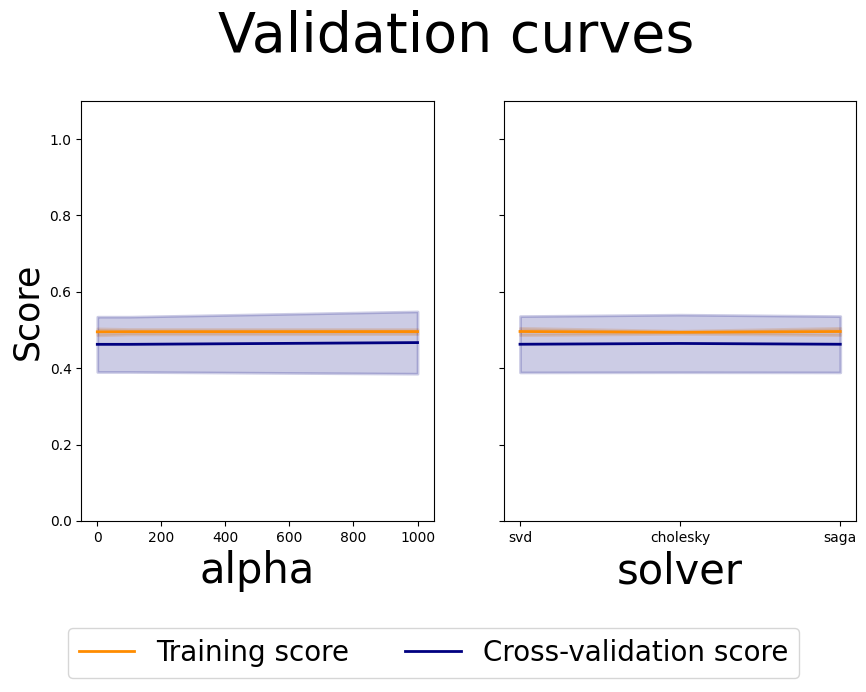

In [213]:
plot_cv_results(ridge.model_cv, ridge.hyper_params[0])

##### Lasso Regression

In [214]:
class LassoRegression() :

    def scoring(self, model, x, y):

        precision = 0
        accuracy = 0
        recall = 0
        f1 = 0
        score = 0
        for i in x['raceId'].unique():
            X_test = x[x['raceId'] == i]
            Y_test = y[x[x['raceId'] == i].index]

            predicted_scores = model.predict(X_test)
            predicted_podium = np.argsort(predicted_scores)[::-1]
            # print(self.position[x[x['raceId'] == i].index])
            actual_podium = self.position[x[x['raceId'] == i].index].to_numpy()
            actual_podium = np.argsort(actual_podium)
            # print(predicted_scores)

            predictions = np.zeros(len(Y_test))
            # predictions[predicted_podium] = 1
            actual = np.zeros(len(Y_test))
            # actual[actual_podium] = 1

            for i in range(1):
                predictions[predicted_podium[i]] = 1
                # print(actual_podium)
                actual[actual_podium[i]] = 1

            precision += precision_score(actual, predictions)
            accuracy += accuracy_score(actual, predictions)
            recall += recall_score(actual, predictions)
            f1 += f1_score(actual, predictions) 
            score += get_score(predicted_podium, actual_podium)
        
        # self.ridge_metrics = {'precision': precision/len(x['raceId'].unique()), 'accuracy': accuracy/len(x['raceId'].unique()), 'recall': recall/len(x['raceId'].unique()), 'f1': f1/len(x['raceId'].unique())}
        return precision/len(x['raceId'].unique())

    def find_best_param_lasso(self, x, y):

        self.x = x
        self.y = y
        self.position = x['results_positionOrder']

        splitter = customCrossValidation().split(x)
        self.hyper_params = [{'alpha': [0.1, 1, 5, 10, 100, 1000], 'selection': ['cyclic', 'random']}]
        # self.hyper_params = [{'alpha': [100, 1000], 'solver': ['svd', 'cholesky']}]

        model_lasso = Lasso()
        self.model_cv = GridSearchCV(estimator=model_lasso, param_grid=self.hyper_params, scoring=self.scoring, cv = splitter, return_train_score=True, verbose = 3)
        self.model_cv.fit(x.drop(columns = ['results_positionOrder']), y)
        self.lasso_params = self.model_cv.best_params_

    def fit_lasso(self, x, y):
        model = Lasso(**self.lasso_params)
        model.fit(x.drop(columns = ['results_positionOrder']), y)
        self.model = model
        return
        


In [215]:
lasso = LassoRegression()

In [216]:
lasso.find_best_param_lasso(df_train.drop(columns = ['results_points']), df_train['results_points'])

Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV 1/3] END alpha=0.1, selection=cyclic;, score=(train=0.487, test=0.529) total time=   0.4s
[CV 2/3] END alpha=0.1, selection=cyclic;, score=(train=0.481, test=0.573) total time=   0.3s
[CV 3/3] END alpha=0.1, selection=cyclic;, score=(train=0.500, test=0.433) total time=   0.3s
[CV 1/3] END alpha=0.1, selection=random;, score=(train=0.487, test=0.529) total time=   0.4s
[CV 2/3] END alpha=0.1, selection=random;, score=(train=0.481, test=0.573) total time=   0.5s
[CV 3/3] END alpha=0.1, selection=random;, score=(train=0.500, test=0.433) total time=   0.4s
[CV 1/3] END alpha=1, selection=cyclic;, score=(train=0.489, test=0.552) total time=   0.4s
[CV 2/3] END alpha=1, selection=cyclic;, score=(train=0.490, test=0.551) total time=   0.4s
[CV 3/3] END alpha=1, selection=cyclic;, score=(train=0.508, test=0.378) total time=   0.3s
[CV 1/3] END alpha=1, selection=random;, score=(train=0.489, test=0.552) total time=   0.3s
[CV 2/3

In [217]:
lasso.lasso_params

{'alpha': 0.1, 'selection': 'cyclic'}

In [218]:
lasso.fit_lasso(df_train.drop(columns = ['results_points']), df_train['results_points'])

In [219]:
get_metrics(lasso.model, df_test.drop(columns = ['results_points']), df_test['results_points'])

(0.45, 0.9526108663781956, 0.45, 0.45, 0.19)

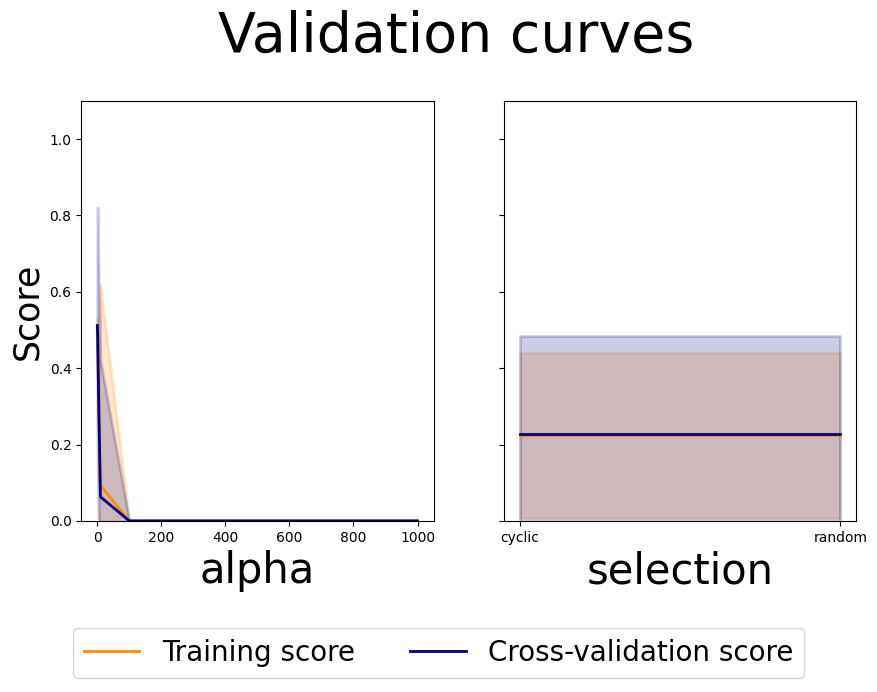

In [220]:
plot_cv_results(lasso.model_cv, lasso.hyper_params[0])